In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import glob

## Combine metrics

In [182]:
df_epoch_metrics_tmp = pd.read_parquet("../../metrics/epoch_metrics/tmp")

In [183]:
df_epoch_metrics_tmp_grid = pd.read_parquet("../../metrics/epoch_metrics/tmp_grid")

In [184]:
epoch_metrics_csv_files_tmp_aris = glob.glob('../../metrics/epoch_metrics/tmp_aris/*.csv')
df_epoch_metrics_df_tmp_aris = pd.concat([pd.read_csv(file) for file in epoch_metrics_csv_files_tmp_aris], ignore_index=True)

In [185]:
df = pd.concat([df_epoch_metrics_tmp, df_epoch_metrics_tmp_grid, df_epoch_metrics_df_tmp_aris])

## Read from `~/metrics/epoch_metrics/` directory

In [51]:
df = pd.read_parquet("../../metrics/epoch_metrics/combined_epoch_metrics.parquet")

In [16]:
df.to_parquet("../../metrics/epoch_metrics/combined_epoch_metrics.parquet")

# Helpful new Dataframe metrics

### Add Helpful Dataset Metrics 

In [186]:
def dataset_n_train(row):
    if row['dataset_name'] == "EMNIST":
        return 60_000
    else:
        return -1


def dataset_one_sample_bytes(row):
    if row['dataset_name'] == "EMNIST":
        # input image 784 tf.float32 pixels and a tf.int32 label
        return 4 * (784 + 1)
    else:
        return -1

In [187]:
df['n_train'] = df.apply(dataset_n_train, axis=1)
df['one_sample_bytes'] = df.apply(dataset_one_sample_bytes, axis=1)

### Add Helpful model metrics

In [188]:
df['model_bytes'] = df['nn_num_weights'] * 4

### Add Helpful FDA method metrics

In [189]:
def fda_local_state_bytes(row):
    if row['fda_name'] == "naive":
        return 4
    if row['fda_name'] == "linear":
        return 8
    if row['fda_name'] == "sketch":
        return row['sketch_width'] * row['sketch_depth'] * 4 + 4

In [190]:
df['local_state_bytes'] = df.apply(fda_local_state_bytes, axis=1)

### Add Total Steps

total steps (a single fda step might have many normal SGD steps, batch steps)

In [191]:
df['total_steps'] = df['total_fda_steps'] * df['num_steps_until_rtc_check']

### Add communication metrics

The communication bytes exchanged for model synchronization. Remember that the Clients send their models to the Server and the Server sends the global model back. This happens at the end of every round.

In [192]:
df['model_bytes_exchanged'] = df['total_rounds'] * df['model_bytes'] * df['num_clients'] * 2

The communication bytes exchanged for monitoring the variance. This happens at the end of every FDA step which consists of `num_steps_until_rtc_check` number of steps. 

In [193]:
df['monitoring_bytes_exchanged'] = df['local_state_bytes'] * df['total_fda_steps'] * df['num_clients']

The total communication bytes exchanged in the whole Federated Learning lifecycle.

In [194]:
df['total_communication_bytes'] = df['model_bytes_exchanged'] + df['monitoring_bytes_exchanged']

In [195]:
df['total_communication_gb'] = df['total_communication_bytes'] / 10**9

In [198]:
df = df.sort_values(by=['dataset_name', 'fda_name', 'nn_num_weights', 'num_clients', 'batch_size', 'num_steps_until_rtc_check', 'theta', 'epoch'])

df['epoch_rounds'] = df.groupby(['dataset_name', 'fda_name', 'nn_num_weights', 'num_clients', 'batch_size', 'num_steps_until_rtc_check', 'theta'])['total_rounds'].diff()

# NaN first epoch
df['epoch_rounds'] = df['epoch_rounds'].fillna(df['total_rounds'])

df['epoch_rounds'] = df['epoch_rounds'].astype(int)

# Plots

In [156]:
# Define styles for each fda_name
fda_styles = {
    'naive': 'o-r',
    'linear': 's-g',
    'sketch': '^-b'
}

In [157]:
theta_values = sorted(df['theta'].unique())
batch_size_values = sorted(df['batch_size'].unique())
epochs_values = sorted(df['epoch'].unique())
num_steps_until_rtc_check_values = sorted(df['num_steps_until_rtc_check'].unique())
fda_names = sorted(df['fda_name'].unique())
num_clients_values = sorted(df['num_clients'].unique())

# Rounds in epoch x-axis Plots

Good

remove  `epoch_plots`

In [204]:
def rounds_in_epoch_plots(df, save_plots=False, pdf_filename='plots/rounds_in_epoch_plots.pdf'):
    
    if save_plots:
        pdf = PdfPages(pdf_filename)
    
    for num_clients in num_clients_values: 
        for theta in theta_values:
            for batch_size in batch_size_values:
                for num_steps_until_rtc_check in num_steps_until_rtc_check_values:
                    # Filter the data for the current combination
                    filtered_data = df[(df['theta'] == theta) &
                                       (df['batch_size'] == batch_size) &
                                       (df['num_clients'] == num_clients) &
                                       (df['num_steps_until_rtc_check'] == num_steps_until_rtc_check)]

                    if filtered_data.empty:
                        continue
                    # Create subplots
                    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))  # Adjust the figsize as needed

                    # Plot the first graph (total_communication_gb)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='epoch')  # Sort the data by 'num_clients'
                        
                        ax1.plot(fda_filtered_data['epoch'], fda_filtered_data['total_communication_gb'],
                                 fda_styles[fda_name], label=fda_name)

                    ax1.set_xlabel('Epochs')
                    ax1.set_ylabel('Communication Cost (GB)')
                    ax1.legend()
                    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                    

                    # Plot the second graph (accuracy)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='epoch')  # Sort the data by 'num_clients'
                        
                        ax2.plot(fda_filtered_data['epoch'], fda_filtered_data['epoch_rounds'],
                                 fda_styles[fda_name], label=fda_name)

                    ax2.set_xlabel('Epochs')
                    ax2.set_ylabel('Rounds In Epoch')
                    ax2.legend()
                    ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                    # Plot the second graph (accuracy)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='epoch')  # Sort the data by 'num_clients'
                        
                        ax3.plot(fda_filtered_data['epoch'], fda_filtered_data['accuracy'],
                                 fda_styles[fda_name], label=fda_name)

                    # Add a single title for the entire figure
                    title = f'Clients: {num_clients}  ,   Theta: {theta}  ,   Batch Size: {batch_size}  ,  Steps per RTC check: {num_steps_until_rtc_check}'
                    fig.suptitle(title)
                    ax3.set_xlabel('Epochs')
                    ax3.set_ylabel('Accuracy')
                    ax3.legend()
                    
                    # Set x-axis limits for ax2
                    #ax2.set_yticks(np.arange(0, 1.1, 0.1))
                    ax3.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                    
                    if save_plots:
                        # Close the current figure to prevent it from being displayed in the notebook
                        plt.close(fig)

                        pdf.savefig(fig)
                        
                    else:
                        # Show the plot
                        plt.show()
    
    # Close the PDF file if save_plots is True
    if save_plots:
        pdf.close()

# Client x-axis Plots

Good

In [158]:
def client_plots(df, save_plots=False, pdf_filename='plots/client_plots.pdf'):
    
    if save_plots:
        pdf = PdfPages(pdf_filename)
    
    # Loop through all unique combinations of num_clients, batch_size, epochs, and num_steps_until_rtc_check
    for theta in theta_values:
        for epochs in epochs_values:
            for batch_size in batch_size_values:
                for num_steps_until_rtc_check in num_steps_until_rtc_check_values:
                    # Filter the data for the current combination
                    filtered_data = df[(df['theta'] == theta) &
                                       (df['batch_size'] == batch_size) &
                                       (df['epoch'] == epochs) &
                                       (df['num_steps_until_rtc_check'] == num_steps_until_rtc_check)]

                    if filtered_data.empty:
                        continue
                        
                    # Create subplots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

                    # Plot the first graph (total_communication_gb)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='num_clients')  # Sort the data by 'num_clients'
                        ax1.plot(fda_filtered_data['num_clients'], fda_filtered_data['total_communication_gb'],
                                 fda_styles[fda_name], label=fda_name)

                    ax1.set_xlabel('Number of Clients')
                    ax1.set_ylabel('Communication Cost (GB)')
                    ax1.legend()
                    ax1.set_xticks(num_clients_values)
                    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                    # Plot the second graph (accuracy)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='num_clients')  # Sort the data by 'num_clients'
                        ax2.plot(fda_filtered_data['num_clients'], fda_filtered_data['accuracy'],
                                 fda_styles[fda_name], label=fda_name)

                    # Add a single title for the entire figure
                    title = f'Theta: {theta}  ,  Epochs: {epochs}  ,  Batch Size: {batch_size}  ,  Steps per RTC check: {num_steps_until_rtc_check}'
                    fig.suptitle(title)
                    ax2.set_xlabel('Number of Clients')
                    ax2.set_ylabel('Accuracy')
                    ax2.legend()
                    ax2.set_xticks(num_clients_values)
                    ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                    
                    if save_plots:
                        # Close the current figure to prevent it from being displayed in the notebook
                        plt.close(fig)

                        pdf.savefig(fig)
                        
                    else:
                        # Show the plot
                        plt.show()
    
    # Close the PDF file if save_plots is True
    if save_plots:
        pdf.close()

# Epoch x-axis Plots

Good

In [159]:
def epoch_plots(df, save_plots=False, pdf_filename='plots/epoch_plots.pdf'):
    
    if save_plots:
        pdf = PdfPages(pdf_filename)
    
    for num_clients in num_clients_values: 
        for theta in theta_values:
            for batch_size in batch_size_values:
                for num_steps_until_rtc_check in num_steps_until_rtc_check_values:
                    # Filter the data for the current combination
                    filtered_data = df[(df['theta'] == theta) &
                                       (df['batch_size'] == batch_size) &
                                       (df['num_clients'] == num_clients) &
                                       (df['num_steps_until_rtc_check'] == num_steps_until_rtc_check)]

                    if filtered_data.empty:
                        continue
                    # Create subplots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

                    # Plot the first graph (total_communication_gb)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='epoch')  # Sort the data by 'num_clients'
                        
                        ax1.plot(fda_filtered_data['epoch'], fda_filtered_data['total_communication_gb'],
                                 fda_styles[fda_name], label=fda_name)

                    ax1.set_xlabel('Epochs')
                    ax1.set_ylabel('Communication Cost (GB)')
                    ax1.legend()
                    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                    

                    # Plot the second graph (accuracy)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='epoch')  # Sort the data by 'num_clients'
                        
                        ax2.plot(fda_filtered_data['epoch'], fda_filtered_data['accuracy'],
                                 fda_styles[fda_name], label=fda_name)

                    # Add a single title for the entire figure
                    title = f'Theta: {theta}  ,  Clients: {num_clients}  ,  Batch Size: {batch_size}  ,  Steps per RTC check: {num_steps_until_rtc_check}'
                    fig.suptitle(title)
                    ax2.set_xlabel('Epochs')
                    ax2.set_ylabel('Accuracy')
                    ax2.legend()
                    
                    # Set x-axis limits for ax2
                    #ax2.set_yticks(np.arange(0, 1.1, 0.1))
                    ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                    
                    if save_plots:
                        # Close the current figure to prevent it from being displayed in the notebook
                        plt.close(fig)

                        pdf.savefig(fig)
                        
                    else:
                        # Show the plot
                        plt.show()
    
    # Close the PDF file if save_plots is True
    if save_plots:
        pdf.close()


# Theta plots

Good

In [161]:
def theta_plots(df, save_plots=False, pdf_filename='plots/theta_plots.pdf'):
    
    if save_plots:
        pdf = PdfPages(pdf_filename)
    
    for num_clients in num_clients_values:
        for epochs in epochs_values:
            for batch_size in batch_size_values:
                for num_steps_until_rtc_check in num_steps_until_rtc_check_values:
                    # Filter the data for the current combination
                    filtered_data = df[(df['num_clients'] == num_clients) &
                                       (df['batch_size'] == batch_size) &
                                       (df['epoch'] == epochs) &
                                       (df['num_steps_until_rtc_check'] == num_steps_until_rtc_check)]

                    if filtered_data.empty:
                        continue
                        
                    # Create subplots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

                    # Plot the first graph (total_communication_gb)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='theta')  # Sort the data by 'num_clients'
                        
                        ax1.plot(fda_filtered_data['theta'], fda_filtered_data['total_communication_gb'],
                                 fda_styles[fda_name], label=fda_name)
                        

                    ax1.set_xlabel('Theta')
                    ax1.set_ylabel('Communication Cost (GB)')
                    ax1.legend()
                    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
                    
                    # Plot the second graph (accuracy)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        fda_filtered_data = fda_filtered_data.sort_values(by='theta') 
                        ax2.plot(fda_filtered_data['theta'], fda_filtered_data['accuracy'],
                                 fda_styles[fda_name], label=fda_name)
                        

                    # Add a single title for the entire figure 
                    title = f' Clients: {num_clients}  ,  Epochs: {epochs}  ,  Batch Size: {batch_size}  ,  Steps per RTC check: {num_steps_until_rtc_check}'
                    fig.suptitle(title)
                    ax2.set_xlabel('Theta')
                    ax2.set_ylabel('Accuracy')
                    ax2.legend()
                    
                    if save_plots:
                        # Close the current figure to prevent it from being displayed in the notebook
                        plt.close(fig)

                        pdf.savefig(fig)
                        
                    else:
                        # Show the plot
                        plt.show()
    
    # Close the PDF file if save_plots is True
    if save_plots:
        pdf.close()

# Batch Size plots

In [55]:
def batch_size_plots():
    # Loop through all unique combinations of num_clients, batch_size, epochs, and num_steps_until_rtc_check
    for num_clients in num_clients_values:
        for epochs in epochs_values:
            for theta in theta_values:
                for num_steps_until_rtc_check in num_steps_until_rtc_check_values:
                    # Filter the data for the current combination
                    filtered_data = df[(df['num_clients'] == num_clients) &
                                       (df['theta'] == theta) &
                                       (df['epoch'] == epochs) &
                                       (df['num_steps_until_rtc_check'] == num_steps_until_rtc_check)]

                    # Create subplots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

                    # Plot the first graph (total_communication_gb)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        ax1.plot(fda_filtered_data['batch_size'], fda_filtered_data['total_communication_gb'],
                                 fda_styles[fda_name], label=fda_name)

                    ax1.set_xlabel('Batch Size')
                    ax1.set_ylabel('Communication Cost (GB)')
                    ax1.legend()

                    # Plot the second graph (accuracy)
                    for fda_name in filtered_data['fda_name'].unique():
                        fda_filtered_data = filtered_data[filtered_data['fda_name'] == fda_name]
                        ax2.plot(fda_filtered_data['batch_size'], fda_filtered_data['accuracy'],
                                 fda_styles[fda_name], label=fda_name)

                    # Add a single title for the entire figure
                    title = f'Clients: {num_clients}  ,  Epochs: {epochs}  ,  Theta: {theta}  ,  Steps per RTC check: {num_steps_until_rtc_check}'
                    fig.suptitle(title)
                    ax2.set_xlabel('Batch Size')
                    ax2.set_ylabel('Accuracy')
                    ax2.legend()

                    # Show the plot
                    plt.show()

# Accuracy / comm cost for everything

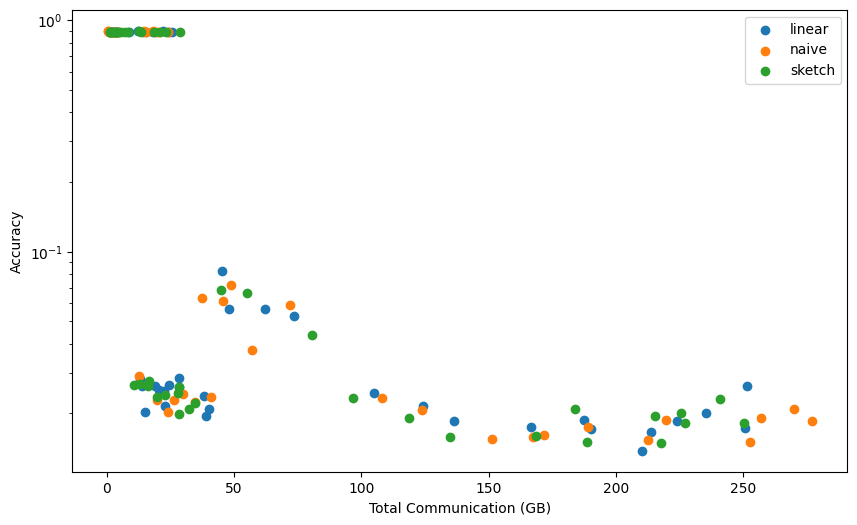

In [132]:
# Create the plot
fig= plt.figure(figsize=(10, 6))

# Plot the data points for each method (fda_name)
for fda_name in fda_names:
    ax = plt.gca()
    fda_filtered_data = df[(df['fda_name'] == fda_name)] 
    fda_filtered_data = fda_filtered_data[fda_filtered_data.epoch == 25]
    plt.scatter(fda_filtered_data['total_communication_gb'], 1 - fda_filtered_data['accuracy'],
                label=fda_name)
    ax.set_yscale('log')

plt.xlabel('Total Communication (GB)')
plt.ylabel('Accuracy')
plt.legend()


plt.show()